In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import copy
import time
import itertools

In [3]:
# 1. 讀資料
df = pd.read_csv('Dataset/weather_dataset.csv')
df

,年,月,日,當地氣壓,海平面氣壓,最大降水量,一小時降水量,10分鐘降水量,平均氣溫,最高氣溫,最低氣溫,平均濕度,最小濕度,日照時間,開花日
0,1961,1,1,1011.7,1012.4,0.0,0.0,0.0,2.1,7.9,-3.9,41.0,15.0,8.6,0
1,1961,1,2,1020.2,1021.0,0.0,0.0,0.0,1.5,9.2,-3.3,51.0,26.0,8.7,0
2,1961,1,3,1021.3,1022.1,0.1,0.8,0.0,2.5,7.3,-2.4,58.0,37.0,5.4,0
3,1961,1,4,1004.6,1005.3,20.2,13.9,3.2,4.7,11.5,0.6,60.0,38.0,1.0,0
4,1961,1,5,1016.3,1017.0,0.0,0.0,0.0,3.8,7.7,1.4,33.0,19.0,8.3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23371,2024,12,27,1006.9,1009.9,0.0,0.0,0.0,7.4,12.7,3.8,51.0,38.0,6.1,0
23372,2024,12,28,1008.1,1011.1,0.0,0.0,0.0,5.4,11.5,1.4,59.0,36.0,7.5,0
23373,2024,12,29,1013.4,1016.4,0.0,0.0,0.0,6.0,12.3,0.5,54.0,31.0,8.9,0
23374,2024,12,30,1017.1,1020.1,0.0,0.0,0.0,6.2,10.3,3.5,53.0,32.0,5.0,0


### 將年, 月, 日欄位重新命名為 year, month, day ，合併成 date 並轉為 datetime格式

In [4]:
# 重新命名 年 月 日 的欄位
df = df.rename(columns={'年': 'year', '月': 'month', '日': 'day'})

# 合併為 datetime 欄位
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])

# 排序
df = df.sort_values(['year', 'month', 'day'])

### 選定訓練時需要的特徵值，並只取每年前120日的氣象資料當作模型的 X

In [5]:
# 2. 特徵挑選與目標
feature_cols = ['當地氣壓', '海平面氣壓', '平均氣溫', '最高氣溫', '最大降水量', '平均濕度']

yearly_sequences = []

for year, group in df.groupby('year'):
    # 只取該年按日期排序後的前120筆
    sub = group.sort_values('date').iloc[:120]
    # 取 feature_cols 對應的欄位
    if len(sub) == 120:  # 避免資料天數不足
        yearly_sequences.append(sub[feature_cols].to_numpy())
    else:
        print(f'⚠️ {year} 年資料不足120天，已略過')

### 將每年開花所需的日數當作模型的 y

In [6]:
X_np = np.stack(yearly_sequences)  # shape=(年數, 120, 特徵數)
y = []
for year, group in df.groupby('year'):
    # 排序後的資料
    group_sorted = group.sort_values('date')
    # 找到開花日=1的那一行
    bloom_rows = group_sorted[group_sorted['開花日'] == 1]
    if len(bloom_rows) > 0:
        # 計算開花日是該年的第幾天 (0-based)
        first_date = group_sorted['date'].iloc[0]
        bloom_date = bloom_rows['date'].iloc[0]
        days_diff = (bloom_date - first_date).days
        y.append(days_diff)
    else:
        print(f"警告: {year}年沒有開花日記錄")
        # 跳過這一年的資料
# y 已經是一個 list，長度等於 yearly_sequences
y_np = np.array(y)   # shape=(年數, )

### 將 X 標準化

In [7]:
# 假設 X_np.shape = (年數, 120, 6)
X_flat = X_np.reshape((X_np.shape[0], -1))

# 對每個特徵單獨標準化
X_scaled = np.zeros_like(X_np)
for i in range(X_np.shape[2]):  # 遍歷6個特徵
    feature_data = X_np[:, :, i]  # (年數, 120)
    scaler = StandardScaler()
    # 將所有年份的該特徵數據平攤用於擬合scaler
    scaler.fit(feature_data.reshape(-1, 1))
    # 對每年的該特徵進行轉換
    for j in range(X_np.shape[0]):  # 遍歷每一年
        X_scaled[j, :, i] = scaler.transform(X_np[j, :, i].reshape(-1, 1)).flatten()

# 然後再平攤用於模型輸入
X_flat_scaled = X_scaled.reshape((X_scaled.shape[0], -1))

### 將 X, y 以 8:2 年代前後順序做切分訓練集與測試集

In [8]:
# 時間順序分割 (最後20%作為測試集)
split_index = int(0.8 * len(X_flat_scaled))
X_train, X_test = X_flat_scaled[:split_index], X_flat_scaled[split_index:]
y_train, y_test = y_np[:split_index], y_np[split_index:]

In [9]:
# 轉換為張量
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

### 設定random seed（50）
### 建立MLP模型：3 of Fully Connected Layers、Loss：MSE、Adam Optimizer、early stop
### 設定網格搜索：hidden state, learning rate, weight Decay, Dropout Rate, Batch Size, Patience
### 使用 R^2 評估模型
### Loss 數據視覺化

開始網格搜索 - 總共 1296 種參數組合

組合 1/1296:
  hidden_sizes: [64, 32, 16]
  learning_rate: 0.0005
  weight_decay: 1e-06
  dropout_rate: 0.2
  batch_size: 4
  patience: 15
  訓練完成: RMSE = 4.5920, 訓練了 297 epochs
  目前最佳 RMSE: 4.5920

組合 2/1296:
  hidden_sizes: [64, 32, 16]
  learning_rate: 0.0005
  weight_decay: 1e-06
  dropout_rate: 0.2
  batch_size: 4
  patience: 20
  訓練完成: RMSE = 4.4266, 訓練了 320 epochs
  目前最佳 RMSE: 4.4266

組合 3/1296:
  hidden_sizes: [64, 32, 16]
  learning_rate: 0.0005
  weight_decay: 1e-06
  dropout_rate: 0.2
  batch_size: 4
  patience: 25
  訓練完成: RMSE = 4.4266, 訓練了 325 epochs
  目前最佳 RMSE: 4.4266

組合 4/1296:
  hidden_sizes: [64, 32, 16]
  learning_rate: 0.0005
  weight_decay: 1e-06
  dropout_rate: 0.2
  batch_size: 8
  patience: 15
  訓練完成: RMSE = 5.5464, 訓練了 500 epochs
  目前最佳 RMSE: 4.4266

組合 5/1296:
  hidden_sizes: [64, 32, 16]
  learning_rate: 0.0005
  weight_decay: 1e-06
  dropout_rate: 0.2
  batch_size: 8
  patience: 20
  訓練完成: RMSE = 5.5464, 訓練了 500 epochs
  目前最佳 RMSE: 4.42

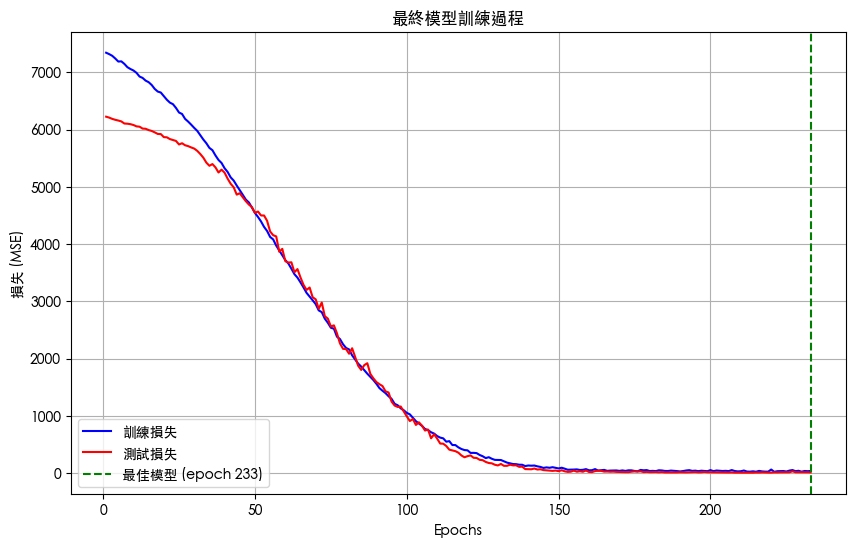


最終模型評估結果:
測試集 MSE: 8.0897
測試集 RMSE: 2.8442 天
R^2 分數: 0.7360


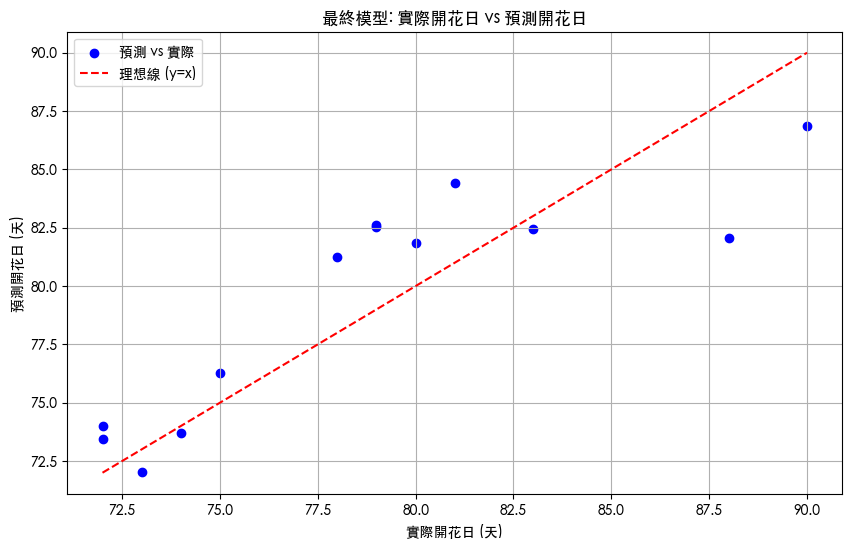

In [10]:
# 設置隨機種子，確保結果可重現
def set_seed(seed=42):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(50)  # 固定隨機種子

# MLP 模型定義
class MLPModel(nn.Module):
    def __init__(self, input_size=720, hidden_sizes=[256, 128, 64], output_size=1, dropout_rate=0.3):
        super(MLPModel, self).__init__()
        
        # 第一個隱藏層
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.bn1 = nn.BatchNorm1d(hidden_sizes[0])
        
        # 第二個隱藏層
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.bn2 = nn.BatchNorm1d(hidden_sizes[1])
        
        # 第三個隱藏層
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.bn3 = nn.BatchNorm1d(hidden_sizes[2])
        
        # 輸出層
        self.fc_out = nn.Linear(hidden_sizes[2], output_size)
        
        # Dropout 層
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.fc3(x)
        x = self.bn3(x)
        x = F.relu(x)
        
        x = self.fc_out(x)
        
        return x

# 訓練和評估模型的函數
def train_and_evaluate(model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, 
                      optimizer, criterion, num_epochs=500, batch_size=8, patience=20, min_delta=0.001):
    
    # 準備 DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # 早停相關變數
    best_loss = float('inf')
    best_model = None
    wait = 0
    stopped_epoch = 0
    
    # 記錄訓練過程
    train_losses = []
    test_losses = []
    
    # 訓練循環
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # 計算平均訓練損失
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        
        # 計算測試損失
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test_tensor)
            test_loss = criterion(test_outputs, y_test_tensor).item()
            test_losses.append(test_loss)
        
        # 早停判斷
        if test_loss < best_loss - min_delta:
            best_loss = test_loss
            wait = 0
            best_model = copy.deepcopy(model.state_dict())
        else:
            wait += 1
            if wait >= patience:
                stopped_epoch = epoch + 1
                break
    
    # 如果完成所有 epoch
    if stopped_epoch == 0:
        stopped_epoch = num_epochs
    
    # 載入最佳模型
    if best_model is not None:
        model.load_state_dict(best_model)
    
    # 最終評估
    model.eval()
    with torch.no_grad():
        test_predictions = model(X_test_tensor)
        final_test_loss = criterion(test_predictions, y_test_tensor).item()
        final_test_rmse = np.sqrt(final_test_loss)
    
    return {
        'model': model,
        'final_test_loss': final_test_loss,
        'final_test_rmse': final_test_rmse,
        'epochs_trained': stopped_epoch,
        'train_losses': train_losses,
        'test_losses': test_losses,
        'best_epoch': stopped_epoch - wait if wait < patience else stopped_epoch
    }

# 網格搜索函數
def grid_search(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, param_grid, verbose=True):
    # 生成所有參數組合
    param_combinations = list(itertools.product(*param_grid.values()))
    param_keys = list(param_grid.keys())
    
    # 最佳結果追蹤
    best_rmse = float('inf')
    best_params = None
    best_result = None
    all_results = []
    
    # 總組合數
    total_combinations = len(param_combinations)
    
    print(f"開始網格搜索 - 總共 {total_combinations} 種參數組合")
    start_time = time.time()
    
    # 逐一嘗試每種參數組合
    for i, combination in enumerate(param_combinations):
        # 構建當前參數字典
        current_params = {param_keys[j]: combination[j] for j in range(len(param_keys))}
        
        if verbose:
            print(f"\n組合 {i+1}/{total_combinations}:")
            for k, v in current_params.items():
                print(f"  {k}: {v}")
        
        # 設置隨機種子確保公平比較
        set_seed(50)
        
        # 初始化模型和優化器
        hidden_sizes = current_params.get('hidden_sizes', [256, 128, 64])
        dropout_rate = current_params.get('dropout_rate', 0.3)
        
        model = MLPModel(
            input_size=X_train_tensor.shape[1], 
            hidden_sizes=hidden_sizes, 
            output_size=1, 
            dropout_rate=dropout_rate
        )
        
        optimizer = optim.Adam(
            model.parameters(), 
            lr=current_params.get('learning_rate', 0.001),
            weight_decay=current_params.get('weight_decay', 1e-5)
        )
        
        criterion = nn.MSELoss()
        
        # 訓練和評估
        result = train_and_evaluate(
            model, 
            X_train_tensor, y_train_tensor, 
            X_test_tensor, y_test_tensor,
            optimizer, 
            criterion,
            num_epochs=current_params.get('num_epochs', 500),
            batch_size=current_params.get('batch_size', 8),
            patience=current_params.get('patience', 20)
        )
        
        # 儲存結果
        result_entry = {
            'params': current_params,
            'test_rmse': result['final_test_rmse'],
            'epochs_trained': result['epochs_trained'],
            'best_epoch': result['best_epoch']
        }
        all_results.append(result_entry)
        
        # 更新最佳結果
        if result['final_test_rmse'] < best_rmse:
            best_rmse = result['final_test_rmse']
            best_params = current_params
            best_result = result
        
        if verbose:
            print(f"  訓練完成: RMSE = {result['final_test_rmse']:.4f}, 訓練了 {result['epochs_trained']} epochs")
            print(f"  目前最佳 RMSE: {best_rmse:.4f}")
    
    # 總耗時
    total_time = time.time() - start_time
    
    print("\n網格搜索完成!")
    print(f"總耗時: {total_time:.2f} 秒")
    print("\n最佳參數組合:")
    for k, v in best_params.items():
        print(f"  {k}: {v}")
    print(f"最佳測試 RMSE: {best_rmse:.4f}")
    
    return {
        'best_params': best_params,
        'best_result': best_result,
        'all_results': all_results
    }

# 使用方式 (假設您已經準備好了資料)
# 這裡先確保 X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor 已經準備好

# 定義網格搜索的參數範圍
param_grid = {
    'hidden_sizes': [
        [64, 32, 16],
        [128, 64, 32],
        [256, 128, 64],
        [512, 256, 128]
    ],
    'learning_rate': [0.0005, 0.001, 0.003],
    'weight_decay': [1e-6, 1e-5, 1e-4],
    'dropout_rate': [0.2, 0.3, 0.4],
    'batch_size': [4, 8, 16, 32],
    'patience': [15, 20, 25]
}

# 執行網格搜索
grid_results = grid_search(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, param_grid)

# 使用最佳參數建立最終模型
best_params = grid_results['best_params']
print("\n使用最佳參數建立最終模型...")

# 設置隨機種子
set_seed(50)

# 初始化最終模型
final_model = MLPModel(
    input_size=X_train_tensor.shape[1], 
    hidden_sizes=best_params['hidden_sizes'], 
    output_size=1, 
    dropout_rate=best_params['dropout_rate']
)

final_optimizer = optim.Adam(
    final_model.parameters(), 
    lr=best_params['learning_rate'],
    weight_decay=best_params['weight_decay']
)

final_criterion = nn.MSELoss()

# 訓練最終模型
final_result = train_and_evaluate(
    final_model, 
    X_train_tensor, y_train_tensor, 
    X_test_tensor, y_test_tensor,
    final_optimizer, 
    final_criterion,
    num_epochs=500,  # 可以設置為更大的值
    batch_size=best_params['batch_size'],
    patience=best_params['patience']
)

# 繪製最終模型的損失曲線
plt.rcParams['font.family'] = 'Heiti TC'  # 設置中文字體
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(final_result['train_losses']) + 1), final_result['train_losses'], label='訓練損失', color='blue')
plt.plot(range(1, len(final_result['test_losses']) + 1), final_result['test_losses'], label='測試損失', color='red')
plt.axvline(x=final_result['best_epoch'], color='green', linestyle='--', label=f'最佳模型 (epoch {final_result["best_epoch"]})')
plt.xlabel('Epochs')
plt.ylabel('損失 (MSE)')
plt.title('最終模型訓練過程')
plt.legend()
plt.grid(True)
plt.savefig('final_model_loss_curve_feature6.png')
plt.show()

# 評估最終模型
final_model.eval()
with torch.no_grad():
    # 測試集評估
    test_predictions = final_model(X_test_tensor)
    test_mse = final_criterion(test_predictions, y_test_tensor).item()
    test_rmse = np.sqrt(test_mse)
    
    # 計算 R^2 分數
    y_test_mean = torch.mean(y_test_tensor)
    ss_tot = torch.sum((y_test_tensor - y_test_mean) ** 2)
    ss_res = torch.sum((y_test_tensor - test_predictions) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    
    print("\n最終模型評估結果:")
    print(f'測試集 MSE: {test_mse:.4f}')
    print(f'測試集 RMSE: {test_rmse:.4f} 天')
    print(f'R^2 分數: {r2.item():.4f}')
    
    # 繪製實際值與預測值的比較圖
    plt.figure(figsize=(10, 6))
    
    # 轉換為 numpy 數組以便繪圖
    y_test_np = y_test_tensor.cpu().numpy().flatten()
    test_pred_np = test_predictions.cpu().numpy().flatten()
    
    # 繪製散點圖
    plt.scatter(y_test_np, test_pred_np, color='blue', label='預測 vs 實際')
    
    # 繪製理想線 (y=x)
    min_val = min(y_test_np.min(), test_pred_np.min())
    max_val = max(y_test_np.max(), test_pred_np.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='理想線 (y=x)')
    
    plt.xlabel('實際開花日 (天)')
    plt.ylabel('預測開花日 (天)')
    plt.title('最終模型: 實際開花日 vs 預測開花日')
    plt.legend()
    plt.grid(True)
    plt.savefig('final_model_predictions_feature6.png')
    plt.show()

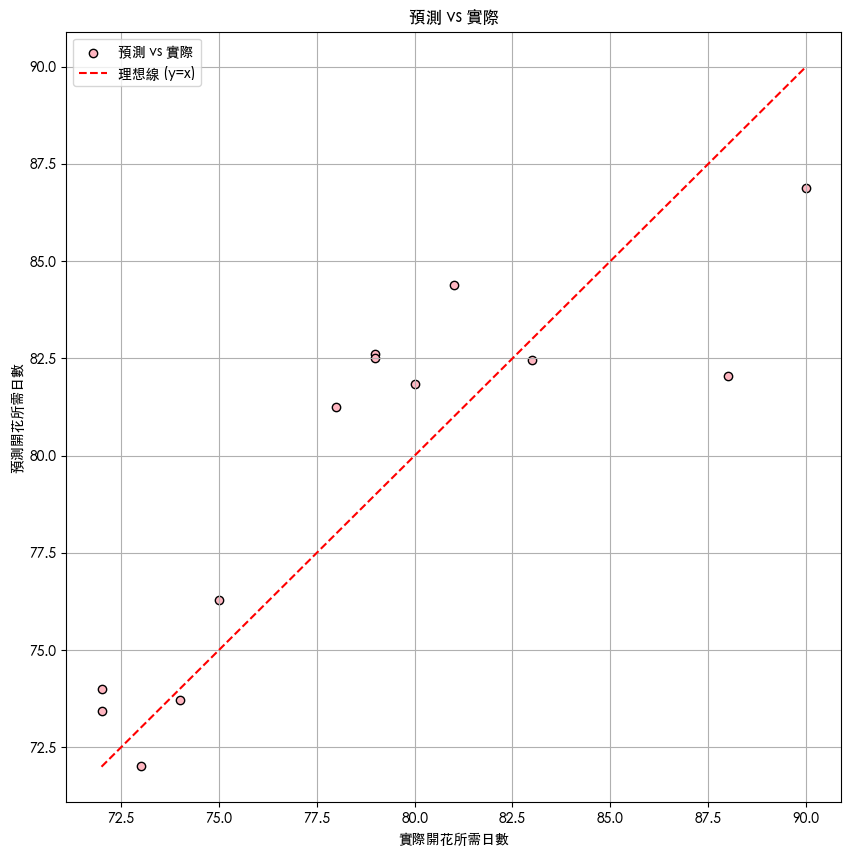

In [11]:
# 繪製實際值與預測值的比較圖
plt.figure(figsize=(5, 5))
    
# 轉換為 numpy 數組以便繪圖
y_test_np = y_test_tensor.cpu().numpy().flatten()
test_pred_np = test_predictions.cpu().numpy().flatten()
    
# 繪製散點圖
plt.scatter(y_test_np, test_pred_np, color='lightpink', edgecolor='black', label='預測 vs 實際')
    
 # 繪製理想線 (y=x)
min_val = min(y_test_np.min(), test_pred_np.min())
max_val = max(y_test_np.max(), test_pred_np.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='理想線 (y=x)')
    
plt.xlabel('實際開花所需日數')
plt.ylabel('預測開花所需日數')
plt.title('預測 vs 實際')
plt.legend()
plt.grid(True)
plt.savefig('final_model_predictions_feature6.png')
plt.show()